# Multiple linear regression
## Introduction
In this notebook I present a linear regression on five variables using gradient descent or the normal equation. The data come from a built-in data set of R called *state.x77* and containing socio-economic data for US states. The data are a bit old as they were collected during the 70s, but more recent data can be found on the website of the [United States Census Bureau](https://www.census.gov/en.html).
## Data import and visualization
First, let's load the modules we will need for this analysis. Pandas is useful to store data in a data frame, Numpy is used to carry out the computations, and Matplotlib will plot the data. We will use Scikitlearn to split the data into training and testing samples.  
I exported a *comma separated value* (csv) file from R, representing a subset of the original data set. This file contains only the variables we are interested in for now: per capita income, the percentage of illiteracy, the murder rate (per 100,000), the percentage of high school graduates and life expectancy.  
The data is imported in a Pandas DataFrame, then we plot variables in pairs to visually check for a correlation.

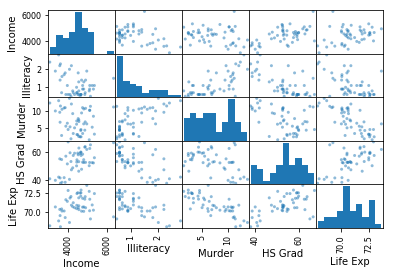

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import data from file
data = pd.read_csv("state-x77-small.csv")
#remove the first column wich is an irrelevant index
data = data[data.columns[1:]]

#plot variables by pair, the first column is ignored as it contains state names
pd.plotting.scatter_matrix(data[1:])
plt.show() #apparently needed when I run the cell manually

The *scatter_matrix* function proposed by Pandas is a bit rough but it looks decent if not too many variables are plotted. Let's say we want to predict life expectancy (the target) from the other variables (the features). By eye, we can spot a correlation between our target, and the *high school graduates* and *murder* features. For the other features, the correlation seems less clear. We will perform a linear regression using multiple features, in order to predict the life expectancy. Let's first define the functions we need for this: the cost function used in the gradient descent, and the normal equation.

In [2]:
#definition of the cost function
def cost(X, Y, theta):
    """Return the mean squared error based on input matrix X, output vector Y, and linear model
    parameters theta"""
    return np.sum((np.dot(X, theta) - Y) ** 2) / 2 / len(Y)

def gradient_descent(X, Y, theta, alpha, n_iter):
    """Return learned parameters theta of linear model as calculated by gradient descent using
    input matrix X, output matrix Y, initial parameters theta, learning rate alpha and
    number of iteration n_iter"""
    #define matrix to store cost history
    cost_history = np.zeros(n_iter)
    #loop for n_iter iterations to perform gradient descent
    for i in range(n_iter):
        delta = np.dot(X.T, (np.dot(X, theta) - Y)) / len(Y) #derivative of cost function
        theta -= alpha * delta
        cost_history[i] = cost(X, Y, theta)
    return theta, cost_history

def norm_eq(X, Y):
    """Return linear regression parameters theta for X and Y by using the normal equation."""
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

We first generate matrices X and Y containing all the data. We then split these matrices into training and testing samples, with the testing samples containing 25 % of the original data.

In [6]:
#generate input matrix (the features used for prediction)
X = np.array(data[data.columns[1]][:, np.newaxis])
for i in range(2, len(data.columns) - 1):
    X = np.concatenate((X, data[data.columns[i]][:, np.newaxis]), axis=1)
    
#generate output vector (the variable we would like to predict)
Y = np.array(data['Life Exp'][:, np.newaxis])

#split X and Y into training and testing samples
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=1)

## Gradient descent
### Data preparation
Let's have a look at the first few rows of data to have a sense of the scale of the data. You can also have a look at the axes on the pair-wise plot above.

In [4]:
data.head()

,state,Income,Illiteracy,Murder,HS Grad,Life Exp
0,Alabama,3624,2.1,15.1,41.3,69.05
1,Alaska,6315,1.5,11.3,66.7,69.31
2,Arizona,4530,1.8,7.8,58.1,70.55
3,Arkansas,3378,1.9,10.1,39.9,70.66
4,California,5114,1.1,10.3,62.6,71.71


 The features span three orders of magnitude, so it makes sens to normalize the data by subtracting the mean and dividing by the standard deviation for each feature element. After normalization we can add a column filled with *1* to the input, to perform vectorized operations.

In [12]:
#feature normalization
mu = np.mean(X_train, axis=0) #rows are collapsed, hence axis=0
sigma = np.std(X_train, axis=0)
X_norm = (X_train - mu) / sigma

#add column of ones to X for vectorized operations
X_norm_ones = np.concatenate((np.ones((len(X_norm), 1)), X_norm), axis=1)

### Parameters calculation
We are now ready to carry out gradient descent on our data. We initialize $\theta$ parameters at zero, we choose a number of iterations and we set the learning rate $\alpha$. We record and plot the history of the cost function results to check how well gradient descent is doing with our parameters.

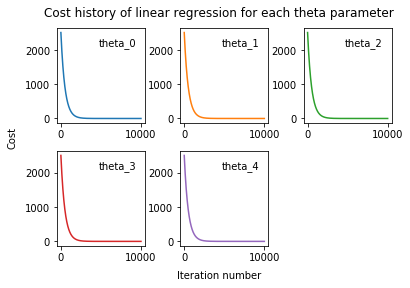

In [13]:
#perform linear regression by gradient descent
m = X_norm_ones.shape[1] #number of columns of X_norm (number of features +1)
theta = np.zeros((m, 1)) #initialize theta
n_iter = 10000
alpha = 0.001 #learning rate
theta, history = gradient_descent(X_norm_ones, Y_train, theta, alpha=alpha, n_iter=n_iter)

#de-normalize theta
mu_one = np.insert(mu, 0, -1)[:, np.newaxis] #insert -1 in first position so we later do subtraction using -sum()
sigma_one = np.insert(sigma, 0, 1)[:, np.newaxis] #insert 1 in first position
theta_denorm = np.copy(theta)
theta_denorm[0] = -np.sum(theta * mu_one / sigma_one) #de-normalize intercept
theta_denorm[1:] = theta_denorm[1:] / sigma_one[1:] #de-normalize other theta parameters

#plot cost history, each theta parameter on a subplots
#with 3 columns
cols = 3
#determine the number of rows
if len(theta) <= 6:
    rows = 2
elif len(facet_names) <= 9:
    rows = 3
else:
    print("Too many parameters")

#generate values for x axis
x_values = [i for i in range(n_iter)]

#get colors for plot lines
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#draw subplots
fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(len(theta)):
    icol = i % 3
    irow = i // 3
    ax[irow, icol].plot(x_values, history, color=colors[i], label="theta_{}".format(i))
    ax[irow, icol].legend(handlelength=0., frameon=False)
fig.text(0.5, 0.01, "Iteration number", ha="center")
fig.text(0.01, 0.5, "Cost", va="center", rotation="vertical")
fig.text(0.5, 0.92, "Cost history of linear regression for each theta parameter", ha="center", fontsize=12)

#adjust distance between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.4)

#delete unused subplots
for i in range(rows*3 -len(theta)):
        fig.delaxes(ax[-1,-(i+1)])
        
plt.show()

The cost converges to a minimum during the chosen number of iterations for each $\theta$ parameter. Each convergence has the same shape, which is expected since the features were normalized before gradient descent.

### Results and model testing
Let's have a look at the values of $\theta$. We will show $\theta$ both before and after application of the normalization coefficients on $\theta$. In the first case we will see the relative contribution of each parameter on the output. In the second case, the parameters will have the same scale as the input.

In [14]:
#print theta parameters
#before 'de-normalization'
param_name = ["intercept"] + list(data.columns.values[1:])
print("\nCalculated theta (gradient descent) before 'de-normalization':")
for i in range(len(theta)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta[i].flat[0], '.4f'),
          sep="")
#after 'de-normalization'
print("\nCalculated theta (gradient descent) after 'de-normalization' :")
for i in range(len(theta_denorm)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta_denorm[i].flat[0], '.4f'),
          sep="")


Calculated theta (gradient descent) before 'de-normalization':
theta_0 (intercept) : 70.9376
theta_1 (Income) : 0.1024
theta_2 (Illiteracy) : 0.1573
theta_3 (Murder) : -0.8546
theta_4 (HS Grad) : 0.4379

Calculated theta (gradient descent) after 'de-normalization' :
theta_0 (intercept) : 68.6027
theta_1 (Income) : 0.0002
theta_2 (Illiteracy) : 0.2558
theta_3 (Murder) : -0.2339
theta_4 (HS Grad) : 0.0564


We can see that the murder rate has the largest impact on life expectancy, and the negative sign of $\theta_3$ is consistent with the apparent negative correlation seen on the pair-wise plot. The percentage of high school graduates is the second largest contributor to life expectancy. Again, the positive sign of $\theta_4$ is consistent with visual examination of the plot. This is a confirmation of our first intuition about what could control life expectancy in US states, at the time the data were collected.
Illiteracy and income have the lowest contribution to life expectancy in our list, a fact reinforced by the discrepancy between the sign of $\theta_2$ and the pair-wise plot.  
We will now test our model on the testing sample. To do so, we will calculate the coefficient of determination $R^2$ which is the ratio between the total sum of squares of the actual output Y and the output Y predicted by the model.

In [15]:
#definition of the total sum of squares
def sst(Y):
    """Return the total sum of squares of Y"""
    return np.sum((Y - np.mean(Y)) ** 2)

#definition of the regression sum of squares
def ssr(X, Y):
    """Return the sum of squares of the difference between predicted output elements and the mean of the actual output"""
    #calculate predicted output of test sample
    Y_pred = np.dot(X, theta_denorm)
    return np.sum((Y_pred - np.mean(Y)) ** 2)
    
#add column filled with "1" to the input train and test samples
X_train_ones = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
X_test_ones = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)

R_sq_train = ssr(X_train_ones, Y_train) / sst(Y_train)
R_sq_test = ssr(X_test_ones, Y_test) / sst(Y_test)
print("Determination coefficient R-squared for the training sample :", format(R_sq_train, '.4f'))
print("Determination coefficient R-squared for the testing sample :", format(R_sq_test, '.4f'))

Determination coefficient R-squared for the training sample : 0.6505
Determination coefficient R-squared for the testing sample : 0.6613


Our model is neither super bad or super good, since around 65 % of the variance in the output can be explained by X and our parameters. We could make our model better by choosing a different set of parameters, for example removing a feature with less apparent correlation with the output, such as income or illiteracy, or both. Let's first try a model without these features.

In [26]:
#generate input matrix (the features used for prediction)
X = np.array(data[data.columns[3]][:, np.newaxis]) #income is in column 1
for i in range(4, len(data.columns) - 1):
    X = np.concatenate((X, data[data.columns[i]][:, np.newaxis]), axis=1)

#split X and Y into training and testing samples
X_train, X_test = train_test_split(X, test_size=.25, random_state=1)

#feature normalization
mu = np.mean(X_train, axis=0) #rows are collapsed, hence axis=0
sigma = np.std(X_train, axis=0)
X_norm = (X_train - mu) / sigma

#add column of ones to X for vectorized operations
X_norm_ones = np.concatenate((np.ones((len(X_norm), 1)), X_norm), axis=1)

#perform linear regression by gradient descent
m = X_norm_ones.shape[1] #number of columns of X_norm (number of features +1)
theta = np.zeros((m, 1)) #initialize theta
n_iter = 10000
alpha = 0.001 #learning rate
theta, history = gradient_descent(X_norm_ones, Y_train, theta, alpha=alpha, n_iter=n_iter)

#de-normalize theta
mu_one = np.insert(mu, 0, -1)[:, np.newaxis] #insert -1 in first position so we later do subtraction using -sum()
sigma_one = np.insert(sigma, 0, 1)[:, np.newaxis] #insert 1 in first position
theta_denorm = np.copy(theta)
theta_denorm[0] = -np.sum(theta * mu_one / sigma_one) #de-normalize intercept
theta_denorm[1:] = theta_denorm[1:] / sigma_one[1:] #de-normalize other theta parameters

#print theta parameters
#before 'de-normalization'
param_name = ["intercept"] + list(data.columns.values[3:])
print("\nCalculated theta (gradient descent) before 'de-normalization':")
for i in range(len(theta)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta[i].flat[0], '.4f'),
          sep="")
#after 'de-normalization'
print("\nCalculated theta (gradient descent) after 'de-normalization' :")
for i in range(len(theta_denorm)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta_denorm[i].flat[0], '.4f'),
          sep="")

#test validity of model
#add column filled with "1" to the input train and test samples
X_train_ones = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
X_test_ones = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)

#calculate R-squared
R_sq_train = ssr(X_train_ones, Y_train) / sst(Y_train)
R_sq_test = ssr(X_test_ones, Y_test) / sst(Y_test)
print("\nDetermination coefficient R-squared for the training sample :", format(R_sq_train, '.4f'))
print("Determination coefficient R-squared for the testing sample :", format(R_sq_test, '.4f'))


Calculated theta (gradient descent) before 'de-normalization':
theta_0 (intercept) : 70.9376
theta_1 (Murder) : -0.7614
theta_2 (HS Grad) : 0.4548

Calculated theta (gradient descent) after 'de-normalization' :
theta_0 (intercept) : 69.3203
theta_1 (Murder) : -0.2084
theta_2 (HS Grad) : 0.0586

Determination coefficient R-squared for the training sample : 0.6539
Determination coefficient R-squared for the testing sample : 0.6438


With less features, the model is not better nor worse. Since this simpler model has the same explanatory power on the output, we would prefer it.

## Normal equation
The normal equation calculates $\theta$ in a single step, which prevents us from having to choose a learning rate and going through many iterations during the gradients descent. Another benefit is that there is no need to normalize the data. However, if the sample size is large (> 10,000), calculation using the normal equation may be longer than gradient descent. We first have to add a column filled with *1* to X to take advantage of vectorized operations.

In [8]:
#add column of ones to X
X_ones = np.concatenate((np.ones((len(data), 1)), X), axis=1)

#calculate theta
theta_norm = norm_eq(X_ones, Y)

#print results
print("\nCalculated theta (gradient descent) :")
for i in range(len(theta_norm)):
    print("theta_",
          i,
          " (",
          param_name[i],
          ") : ",
          format(theta_norm[i].flat[0], '.4f'),
          sep="")


Calculated theta (gradient descent) :
theta_0 (intercept) : 69.4833
theta_1 (Income) : 0.0001
theta_2 (Illiteracy) : 0.2761
theta_3 (Murder) : -0.2619
theta_4 (HS Grad) : 0.0461


The results largely agree with what we obtained for the gradient descent.